# Задание 5. Извлечение данных 

## Задание 5.1

Напишите скрипт, который скачивает  сообщения с Телеграм-канала https://t.me/Sputnik_results . Сохраните сообщения в формате по вашему выбору (.csv, .jsonl, sqlite, parquet, и т.д.). Откройте с помощью Pandas или аналогичных библиотек, постройте график числа сообщений в зависимости от даты. 

## Задание 5.2
1.Напишите функции для извлечения данных из сообщений:
   - пол участника
   - возраст участника

   Постройте диаграммы для визуализации. 

2.Реализуйте какой-либо анализ этих данных на ваше усмотрение. Например их можно кластеризовать и интерпретировать кластеры, или попробовать выделить статистику по среднему количеству антител в зависимости от возраста, или посчитать количество заболевших после вакцинации. Обязательна визуализация. 

In [3]:
import configparser
import json
import asyncio
from datetime import date, datetime
import seaborn as sns
import re
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.colors as mcolors

In [ ]:
from telethon import TelegramClient
from telethon.errors import SessionPasswordNeededError
from telethon.tl.functions.messages import (GetHistoryRequest)
from telethon.tl.types import (PeerChannel)

In [ ]:
import configparser
import json

from telethon.sync import TelegramClient
from datetime import datetime
from telethon.tl.functions.messages import GetHistoryRequest

class DateTimeEncoder(json.JSONEncoder):

    def default(self, o):
        if isinstance(o, datetime):
            return o.isoformat()
        if isinstance(o, bytes):
            return list(o)
        return json.JSONEncoder.default(self, o)
    
    
async def parseMessages(channel):
    offset_msg = 0
    limit_msg = 100

    all_messages = []
    total_messages = 0
    total_count_limit = 0


    while True:
        history = await client(GetHistoryRequest(
            peer=channel,
            offset_id=offset_msg,
            offset_date=None, add_offset=0,
            limit=limit_msg, max_id=0, min_id=0,
            hash=0))
        if not history.messages:
            break
        messages = history.messages
        for message in messages:
            all_messages.append(message.to_dict())
        offset_msg = messages[len(messages) - 1].id
        total_messages = len(all_messages)
        if total_count_limit != 0 and total_messages >= total_count_limit:
            break

    with open('tg.json', 'w', encoding='utf8') as outfile:
        json.dump(all_messages, outfile, ensure_ascii=False, cls=DateTimeEncoder)

#api_id = 
#api_hash = 
#username = 

client = TelegramClient(username, api_id, api_hash)

client.start()


async def main():
    url = "https://t.me/Sputnik_results"
    channel = await client.get_entity(url)
    await parseMessages(channel)


with client:
    client.loop.run_until_complete(main())

In [4]:
df = pd.read_json('tg.json')
df = df[['date', 'message']]
df.date = df.date.dt.date
df_date = df.groupby('date', as_index=False).aggregate({'message':"count"})

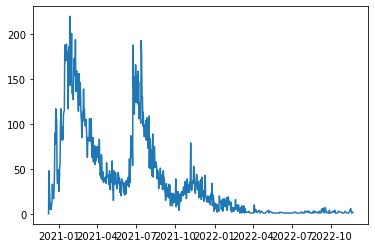

In [5]:
plt.plot(df_date.date, df_date.message)

In [7]:
df[['gender','age']] = df.message.str.extract(r'(мужчина|женщина|[МЖмж])[^a-zа-я0-9]*(\d+)', flags=re.IGNORECASE)
df = df[~df.gender.isnull() & ~df.age.isnull()]
df.gender = df.gender.str.lower()
df.gender = df.gender.str[0]

In [8]:
df_m_f = df.groupby('gender', as_index=False).aggregate({'message':'count'})
df_m_f

,gender,message
0,ж,9893
1,м,6387


/Users/angelinasharova/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gender', ylabel='message'>

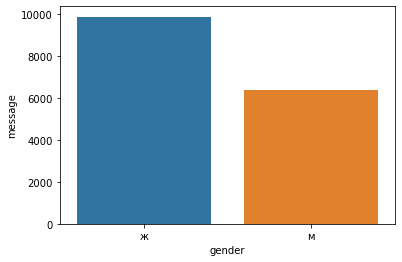

In [10]:
sns.barplot(df_m_f.gender, df_m_f.message)

In [11]:
df = df[df['message'].str.contains('bau|BAU|Bau')]
df['BAU'] = df['message'].str.extract('(...[0123456789.,][0123456789][0123456789].BAU)', flags=re.IGNORECASE, expand=False).str.upper()
df['BAU'] = df['BAU'].str.replace(' bau', '')
df['BAU'] = df['BAU'].str.replace(',', '.')
df['BAU'] = df['BAU'].str.replace('.[0123456789][.]', '')
df['BAU'] = df['BAU'].str.replace('(\D)', '')
df = df[df['BAU'].str.len() < 5]
df['BAU'] = pd.to_numeric(df['BAU'], errors='ignore')



/var/folders/zj/3n_jg8g55b78my0mk2snjhk80000gn/T/ipykernel_3362/1720356472.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['BAU'] = df['BAU'].str.replace('.[0123456789][.]', '')
/var/folders/zj/3n_jg8g55b78my0mk2snjhk80000gn/T/ipykernel_3362/1720356472.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['BAU'] = df['BAU'].str.replace('(\D)', '')


In [12]:
dbsc = DBSCAN(eps=0.3, min_samples=10).fit(df[['age', 'BAU']])

In [13]:
X = df[['age', 'BAU']]

In [14]:
labels = dbsc.labels_

In [15]:
no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 1
Estimated no. of noise points: 407


<BarContainer object of 407 artists>

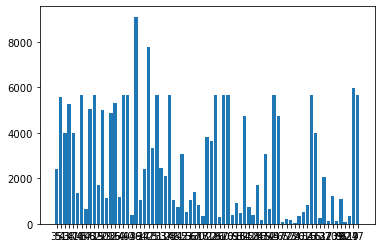

In [16]:
plt.bar(df.age, df.BAU)